In [2]:

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
from scipy.stats.stats import pearsonr   
from lazypredict.Supervised import LazyClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import scipy.stats as stat
import pylab 
import jsonpickle
import json


In [3]:
data = pd.read_csv('Data/Preprocessed/final.csv')

## 1. Feature Selection 

#### Looking for low variance features

In [4]:

var_thres=VarianceThreshold(threshold=0.0)
var_thres.fit(data)


VarianceThreshold()

No columns has suffieciintly low variance

### Looking for correlations

<AxesSubplot:>

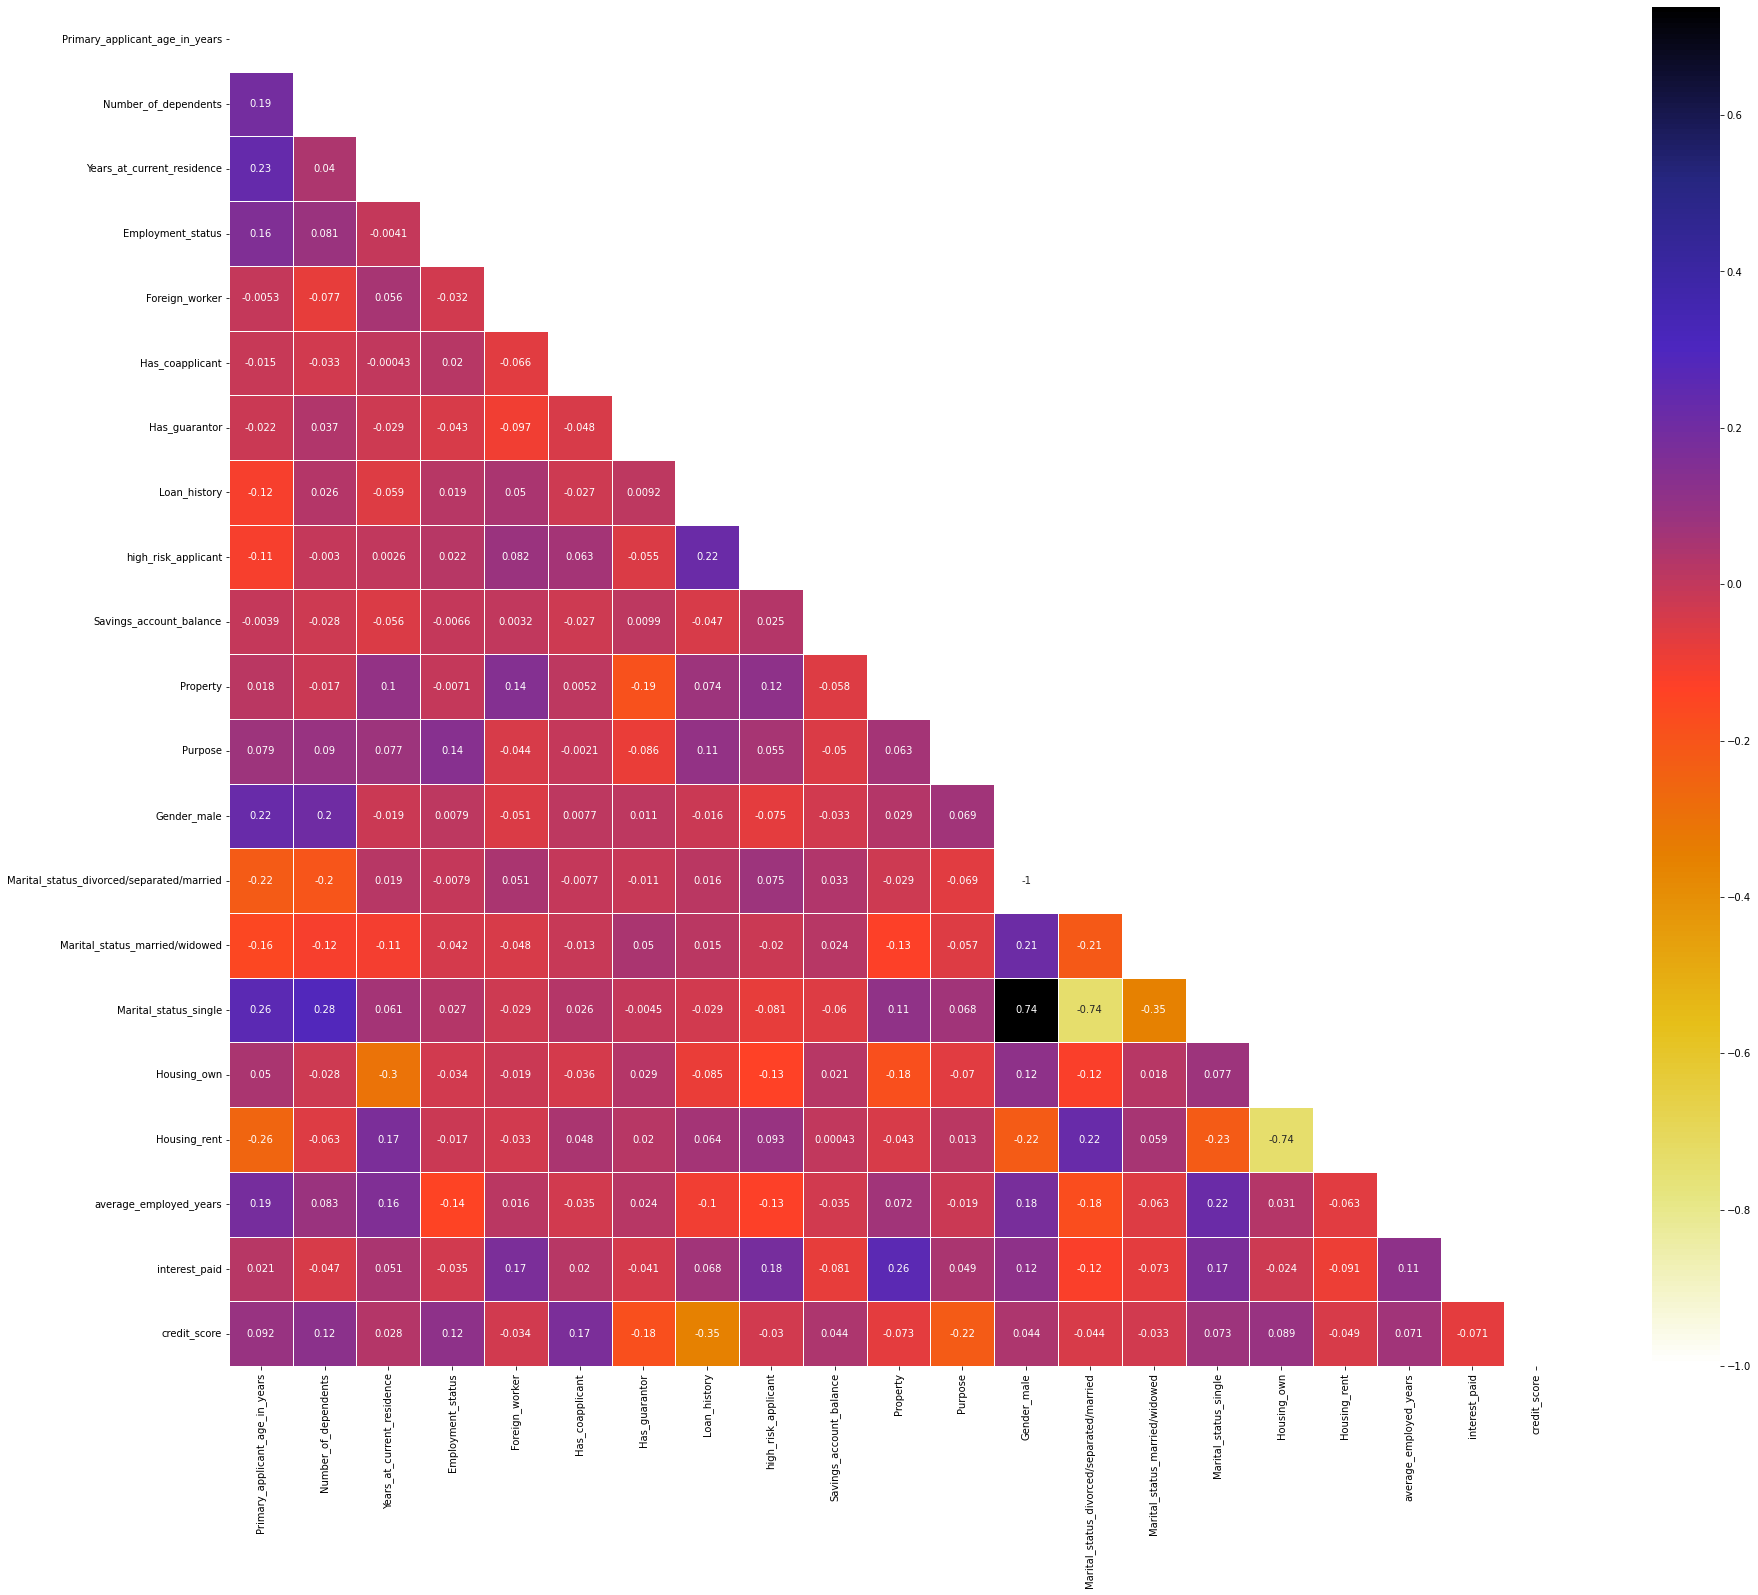

In [5]:
figure(figsize=(30, 25))
mask = np.zeros_like(data.corr('spearman'))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr('spearman'), annot=True, cmap=plt.cm.CMRmap_r, linewidths=.5, mask=mask)

From the above chart we can infer that the features (except for the one hot encodings)  are not much significantly correlated

### Using Mututal Info Classifier

In [6]:

# determine the mutual information
X= data[data.columns.drop('high_risk_applicant')]
Y = data['high_risk_applicant']
mutual_info = pd.Series(mutual_info_classif(X, Y))

In [7]:
cols = X.columns

In [8]:
data.shape

(1000, 21)

In [9]:
mi_score_selected_index = np.where(mutual_info >0.0)[0]
mi_score_selected_index

imp_cols = [cols[i] for i in mi_score_selected_index ]
imp_cols 
    

['Number_of_dependents',
 'Foreign_worker',
 'Has_coapplicant',
 'Has_guarantor',
 'Loan_history',
 'Property',
 'Purpose',
 'Marital_status_married/widowed',
 'Marital_status_single',
 'Housing_own',
 'Housing_rent',
 'average_employed_years',
 'interest_paid']

<AxesSubplot:>

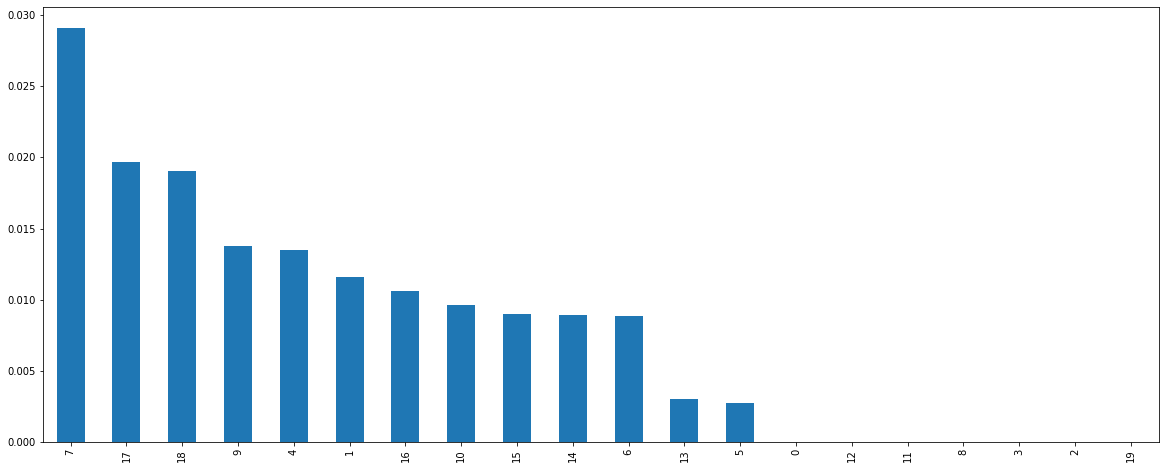

In [10]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [11]:
train_x, test_x,train_y, test_y = train_test_split(X[imp_cols],Y, shuffle = True, stratify=Y)

In [12]:
clf = LazyClassifier(predictions=True)

models, predictions = clf.fit(train_x, test_x,train_y, test_y)

 90%|████████▉ | 26/29 [00:02<00:00, 11.60it/s]

[00:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [00:03<00:00,  7.49it/s]


In [13]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.64,0.65,0.65,0.66,0.02
NearestCentroid,0.63,0.65,0.65,0.65,0.03
RandomForestClassifier,0.72,0.62,0.62,0.70,0.48
QuadraticDiscriminantAnalysis,0.65,0.62,0.62,0.66,0.03
AdaBoostClassifier,0.72,0.61,0.61,0.70,0.23
LGBMClassifier,0.70,0.61,0.61,0.69,0.21
XGBClassifier,0.69,0.61,0.61,0.68,1.14
BaggingClassifier,0.70,0.61,0.61,0.69,0.10
ExtraTreeClassifier,0.66,0.59,0.59,0.66,0.02


### Using Select KBEST

In [14]:
ks = [i for i in range(5, 20)]

sel_five_cols = SelectKBest(mutual_info_classif, k=20)
sel_five_cols.fit(X, Y)
top10 = list(X.columns[sel_five_cols.get_support()])

x = X[top10]

In [15]:
k_wise_scores = []
for i in ks:
    sel_five_cols = SelectKBest(mutual_info_classif, k=i)
    sel_five_cols.fit(X, Y)
    top_k = list(X.columns[sel_five_cols.get_support()])
    x = X[top_k]
    train_x, test_x,train_y, test_y = train_test_split(x,Y, shuffle = True, stratify=Y)
    clf = LazyClassifier(predictions=True)
    models, predictions = clf.fit(train_x, test_x,train_y, test_y)
    k_wise_scores.append(models['Balanced Accuracy'][0])
    

 86%|████████▌ | 25/29 [00:02<00:00, 11.13it/s]

[00:28:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 12.50it/s]

[00:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:01<00:00, 14.86it/s]

[00:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00,  9.02it/s]

[00:28:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 10.40it/s]

[00:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 13.21it/s]

[00:28:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 13.60it/s]

[00:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 12.88it/s]

[00:28:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 12.87it/s]

[00:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 13.24it/s]

[00:28:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 13.07it/s]

[00:28:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 12.80it/s]

[00:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 12.75it/s]

[00:28:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:02<00:00, 10.19it/s]

[00:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:02<00:00, 12.71it/s]

[00:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [00:03<00:00,  8.97it/s]


Text(0, 0.5, 'Best Model Accuracy')

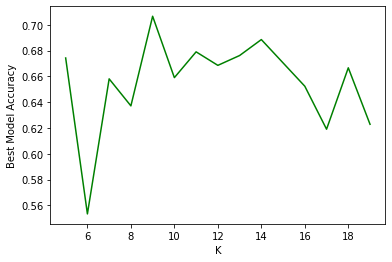

In [16]:
plt.plot(ks, k_wise_scores, color = 'g')
plt.xlabel('K')
plt.ylabel('Best Model Accuracy')


<b>As we can see the spike is maximum at random and hence, we would be considering the all the features<b>

In [17]:
# sel_five_cols = SelectKBest(mutual_info_classif, k=9)
# sel_five_cols.fit(X, Y)
# top_k = list(X.columns[sel_five_cols.get_support()])
# X = X[top_k]

In [18]:
train_x, test_x,train_y, test_y = train_test_split(x,Y, shuffle = True, stratify=Y)
clf = LazyClassifier(predictions=True)

models, predictions = clf.fit(train_x, test_x,train_y, test_y)

 90%|████████▉ | 26/29 [00:02<00:00, 11.24it/s]

[00:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [00:03<00:00,  8.15it/s]


In [19]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.68,0.65,0.65,0.69,0.03
QuadraticDiscriminantAnalysis,0.69,0.64,0.64,0.69,0.03
LinearDiscriminantAnalysis,0.74,0.63,0.63,0.72,0.05
AdaBoostClassifier,0.72,0.63,0.63,0.71,0.29
NearestCentroid,0.64,0.63,0.63,0.65,0.03
LogisticRegression,0.73,0.62,0.62,0.71,0.05
ExtraTreesClassifier,0.74,0.62,0.62,0.71,0.42
LinearSVC,0.73,0.61,0.61,0.70,0.15
LGBMClassifier,0.69,0.60,0.60,0.68,0.23


## 2. Model Building

<b> I would like to mention few points before starting building a modek</b>

<i>Business Constraint: Note that it is worse to state an applicant as a low credit risk when they are actually a high risk, than it is to state an applicant to be a high credit risk when they aren’t.</i>

<li> The above problem states that we should aim to minimize the False Positives or the Type 1 error should me Minimized!. </li>

<li> To minimize the Type one errors or False Positives we must focus on models having more <b>Precision</b></li>

<li>Since the dataset is nearing an imbalance, it makes it necesaary to stratify our splits. Hence, we will be performing Stratified Train, Test Splits and Stratified KFold while building the model</li>

<li>Since, the dataset is nearning an imbalance and we also, do not have the sufficient data to undersample it. we will be <b> OverSampling </b> the the data and train the model accordningly</li>

<li>We will be building 2 models with imblearn library which can deal with imbalanced dataset.</li>

In [20]:
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score,confusion_matrix,classification_report, precision_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


In [21]:
train_x, test_x,train_y, test_y = train_test_split(X,Y, shuffle = True, stratify=Y, random_state=1)

In [22]:
os=SMOTETomek(0.75)
X_train_ns,y_train_ns=os.fit_resample(train_x,train_y)


In [23]:
test_y.shape

(250,)

## Training a Random Forest Classifier

In [24]:
model = RandomForestClassifier()
model.fit(X_train_ns,y_train_ns)
y_pred=model.predict(test_x)


In [25]:
cm = confusion_matrix(test_y,y_pred)
print(balanced_accuracy_score(test_y,y_pred))
print(classification_report(test_y,y_pred))

0.62
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       175
           1       0.52      0.40      0.45        75

    accuracy                           0.71       250
   macro avg       0.64      0.62      0.63       250
weighted avg       0.69      0.71      0.70       250



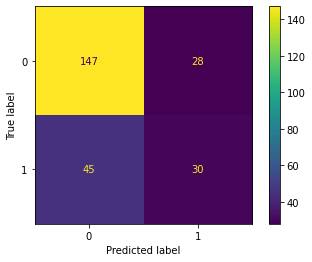

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Training a LogisticRegression Classifer

In [27]:
logistic_model = LogisticRegression()
logistic_model.fit(train_x, train_y)
y_pred = logistic_model.predict(test_x)

In [28]:
cm = confusion_matrix(test_y,y_pred)
print(balanced_accuracy_score(test_y,y_pred))
print(classification_report(test_y,y_pred))

0.599047619047619
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       175
           1       0.55      0.31      0.39        75

    accuracy                           0.72       250
   macro avg       0.65      0.60      0.60       250
weighted avg       0.69      0.72      0.69       250



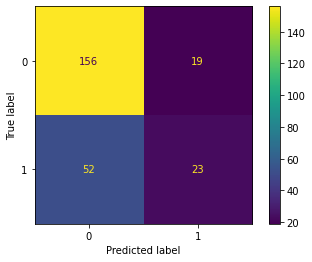

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

<b>From the above 2 models we can conclude that the Logistic regression is a better classifer, since it is maximizing the Precision. <b/>

## Hyperparameter Tuning

In [30]:


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [31]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(train_x,train_y)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

In [32]:
rf_randomcv.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 560,
 'criterion': 'entropy'}

In [33]:
best_random_grid=rf_randomcv.best_estimator_

In [34]:
from sklearn.metrics import accuracy_score
y_pred=best_random_grid.predict(test_x)
print(confusion_matrix(test_y,y_pred))
print("Accuracy Score {}".format(accuracy_score(test_y,y_pred)))
cm_rfc_tuned = confusion_matrix(test_y,y_pred)
print("Classification report: {}".format (classification_report(test_y,y_pred)))

[[164  11]
 [ 54  21]]
Accuracy Score 0.74
Classification report:               precision    recall  f1-score   support

           0       0.75      0.94      0.83       175
           1       0.66      0.28      0.39        75

    accuracy                           0.74       250
   macro avg       0.70      0.61      0.61       250
weighted avg       0.72      0.74      0.70       250



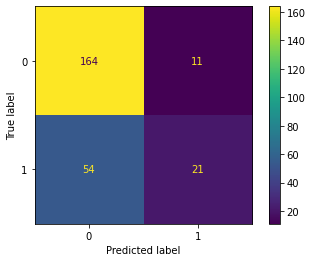

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc_tuned)
disp.plot()